# EduVerse USA Chatbot — Named Entity Recognition

## NLP Pipeline Module 3

This notebook extracts academic entities from user queries.

### Entity Types
- **Universities**: MIT, Stanford, USC
- **Programs**: MS in Computer Science, PhD in ML
- **Locations**: US states (CA, NY, TX)
- **Tests**: GRE, TOEFL, IELTS
- **Deadlines**: Fall 2026, Dec 15
- **Scores**: GPA 3.8, TOEFL 105

### Approach
Rule-based extraction with regex patterns and gazetteers, plus spaCy integration.

---
## 1. Setup

In [ ]:
!pip install spacy pandas matplotlib -q
!python -m spacy download en_core_web_sm -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [ ]:
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from dataclasses import dataclass
from typing import List, Dict

import spacy
from spacy import displacy

nlp = spacy.load('en_core_web_sm')
print("Setup complete")

Setup complete


---
## 2. Entity Gazetteers

In [ ]:
# University names
UNIVERSITIES = [
    "mit", "stanford", "harvard", "carnegie mellon", "cmu",
    "uc berkeley", "berkeley", "usc", "nyu", "columbia",
    "cornell", "princeton", "yale", "ucla", "caltech"
]

# US states
US_STATES = {
    "california": "CA", "ca": "CA",
    "new york": "NY", "ny": "NY",
    "texas": "TX", "tx": "TX",
    "massachusetts": "MA", "ma": "MA"
}

# Standardized tests
TESTS = ["gre", "toefl", "ielts", "gmat"]

print(f"Universities: {len(UNIVERSITIES)}")
print(f"States: {len(US_STATES)}")
print(f"Tests: {len(TESTS)}")

Universities: 15
States: 8
Tests: 4


---
## 3. Regex Patterns

In [ ]:
# Program patterns
PROGRAM_PATTERNS = [
    r'\b(ms|master\'?s?)\s+(in\s+)?([a-z\s]+)',
    r'\b(phd|doctorate)\s+(in\s+)?([a-z\s]+)',
    r'\bcomputer\s+science\b',
    r'\bdata\s+science\b',
    r'\bmachine\s+learning\b'
]

# Deadline patterns
DEADLINE_PATTERNS = [
    r'\b(fall|spring)\s+20\d{2}\b',
    r'\b(jan|feb|mar|apr|may|jun|jul|aug|sep|oct|nov|dec)[a-z]*\s+\d{1,2}\b'
]

# Score patterns
SCORE_PATTERNS = {
    'gpa': r'\bgpa\s*[:\-]?\s*(\d\.\d{1,2})\b',
    'toefl': r'\btoefl\s*[:\-]?\s*(\d{2,3})\b',
    'ielts': r'\bielts\s*[:\-]?\s*(\d(?:\.\d)?)\b',
    'gre': r'\bgre\s*[:\-]?\s*(\d{3})\b'
}

---
## 4. Entity Extraction Function

In [ ]:
@dataclass
class Entities:
    universities: List[str]
    programs: List[str]
    locations: List[str]
    tests: List[str]
    deadlines: List[str]
    scores: Dict[str, str]


def extract_entities(text: str) -> Entities:
    """Extract academic entities from text."""
    text_lower = text.lower()
    
    # Universities
    universities = [u.title() for u in UNIVERSITIES if u in text_lower]
    universities = list(set(universities))
    
    # Programs
    programs = []
    for pattern in PROGRAM_PATTERNS:
        for m in re.finditer(pattern, text_lower):
            programs.append(m.group(0).strip())
    programs = list(set(programs))
    
    # Locations
    locations = []
    for state, abbrev in US_STATES.items():
        if state in text_lower:
            locations.append(abbrev)
    locations = list(set(locations))
    
    # Tests
    tests = [t.upper() for t in TESTS if t in text_lower]
    tests = list(set(tests))
    
    # Deadlines
    deadlines = []
    for pattern in DEADLINE_PATTERNS:
        for m in re.finditer(pattern, text_lower):
            deadlines.append(m.group(0))
    
    # Scores
    scores = {}
    for score_type, pattern in SCORE_PATTERNS.items():
        m = re.search(pattern, text_lower)
        if m:
            scores[score_type] = m.group(1)
    
    return Entities(universities, programs, locations, tests, deadlines, scores)

---
## 5. Test Extraction

In [ ]:
test_queries = [
    "I want MS in Computer Science at Stanford for Fall 2026. GPA: 3.8",
    "What's the TOEFL requirement for MIT? I scored 105.",
    "PhD programs in Machine Learning at UC Berkeley, California.",
    "USC deadline is Dec 15. I need GRE 320 and IELTS 7.0"
]

for query in test_queries:
    ent = extract_entities(query)
    print(f"\nQuery: {query}")
    print(f"  Universities: {ent.universities}")
    print(f"  Programs: {ent.programs}")
    print(f"  Tests: {ent.tests}")
    print(f"  Scores: {ent.scores}")
    print(f"  Deadlines: {ent.deadlines}")


Query: I want MS in Computer Science at Stanford for Fall 2026. GPA: 3.8
  Universities: ['Stanford']
  Programs: ['computer science', 'ms in computer science at stanford for fall']
  Tests: []
  Scores: {'gpa': '3.8'}
  Deadlines: ['fall 2026']

Query: What's the TOEFL requirement for MIT? I scored 105.
  Universities: ['Mit']
  Programs: []
  Tests: ['TOEFL']
  Scores: {}
  Deadlines: []

Query: PhD programs in Machine Learning at UC Berkeley, California.
  Universities: ['Berkeley', 'Uc Berkeley']
  Programs: ['machine learning', 'phd programs in machine learning at uc berkeley']
  Tests: []
  Scores: {}
  Deadlines: []

Query: USC deadline is Dec 15. I need GRE 320 and IELTS 7.0
  Universities: ['Usc']
  Programs: []
  Tests: ['GRE', 'IELTS']
  Scores: {'ielts': '7.0', 'gre': '320'}
  Deadlines: ['dec 15']


---
## 6. spaCy NER

In [ ]:
sample = "I want to study at MIT in Massachusetts starting Fall 2026."
doc = nlp(sample)

print(f"Text: {sample}\n")
print("spaCy Entities:")
for ent in doc.ents:
    print(f"  {ent.text} → {ent.label_}")

Text: I want to study at MIT in Massachusetts starting Fall 2026.

spaCy Entities:
  MIT → ORG
  Massachusetts → GPE
  Fall 2026 → DATE


In [ ]:
# Visualize
displacy.render(doc, style='ent', jupyter=True)

---
## 7. Combined Pipeline

In [ ]:
def combined_ner(text):
    """Combine rule-based and spaCy NER."""
    # Rule-based
    rule_ent = extract_entities(text)
    
    # spaCy
    doc = nlp(text)
    spacy_ent = {}
    for ent in doc.ents:
        if ent.label_ not in spacy_ent:
            spacy_ent[ent.label_] = []
        spacy_ent[ent.label_].append(ent.text)
    
    return {'rule_based': rule_ent, 'spacy': spacy_ent}

# Test
result = combined_ner("John wants to apply to Stanford in California for PhD in AI. GRE: 325")

print("Rule-based:")
print(f"  Universities: {result['rule_based'].universities}")
print(f"  Programs: {result['rule_based'].programs}")
print(f"  Scores: {result['rule_based'].scores}")

print("\nspaCy:")
for label, entities in result['spacy'].items():
    print(f"  {label}: {entities}")

Rule-based:
  Universities: ['Stanford']
  Programs: ['phd in ai']
  Scores: {'gre': '325'}

spaCy:
  PERSON: ['John']
  ORG: ['Stanford', 'GRE']
  GPE: ['California', 'AI']
  WORK_OF_ART: ['PhD']
  CARDINAL: ['325']


---
## 8. Entity Distribution

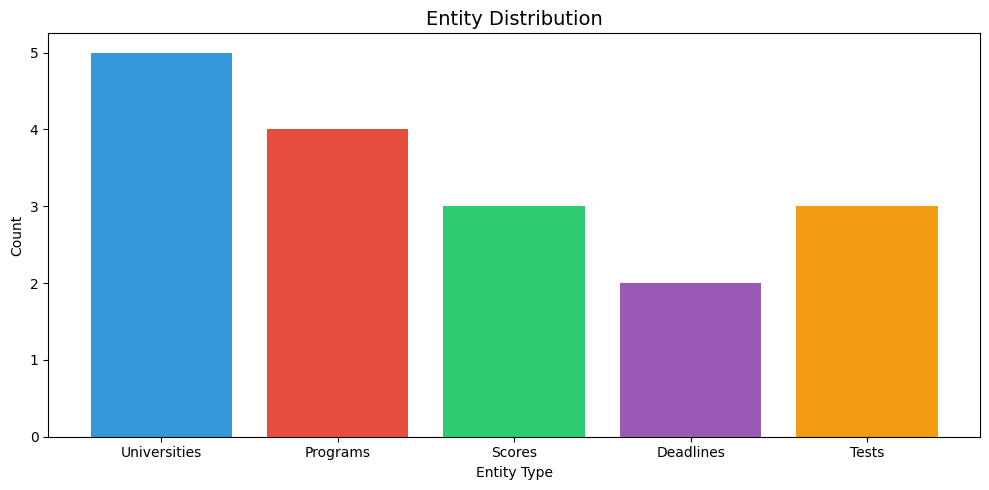

In [ ]:
entity_counts = defaultdict(int)

for query in test_queries:
    ent = extract_entities(query)
    if ent.universities: entity_counts['Universities'] += len(ent.universities)
    if ent.programs: entity_counts['Programs'] += len(ent.programs)
    if ent.tests: entity_counts['Tests'] += len(ent.tests)
    if ent.scores: entity_counts['Scores'] += len(ent.scores)
    if ent.deadlines: entity_counts['Deadlines'] += len(ent.deadlines)

plt.figure(figsize=(10, 5))
colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12']
plt.bar(entity_counts.keys(), entity_counts.values(), color=colors)
plt.title('Entity Distribution', fontsize=14)
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

---
## 9. Summary

### NER Approach
- **Rule-based**: Domain-specific entities (universities, programs, tests, scores)
- **spaCy**: General entities (names, dates, locations)
- **Combined**: Best of both approaches

### Key Takeaways
1. Gazetteers effectively capture university names
2. Regex patterns handle structured entities (scores, dates)
3. spaCy complements with general entity recognition